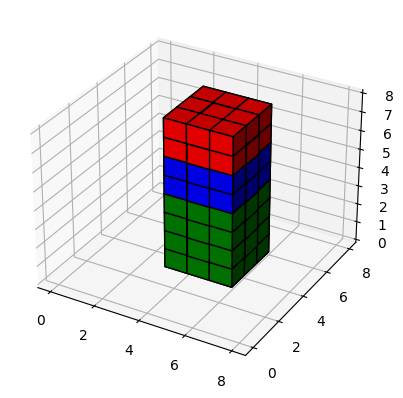

In [4]:
from artefact_nca.dataset.voxel_dataset import VoxelDataset
from artefact_nca.model.voxel_ca_model import VoxelCAModel
from artefact_nca.trainer.voxel_ca_trainer import VoxelCATrainer


import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z < 4)
cube2 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 4) & (z < 6)
cube3 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 6) & (z < 8) 

# link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | cube3

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[cube3] = 'red'
colors[cube1] = 'green'
colors[cube2] = 'blue'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

from artefact_nca.utils.minecraft.voxel_utils import voxel_to_numeric

voxel, target_unique_val_dict = voxel_to_numeric(colors)


In [5]:
import torch
print(torch.cuda.is_available())


False


In [6]:
import attr
import torch.nn.functional as F
import torch
import numpy as np
from einops import rearrange

@attr.s
class CustomMSETrainer(VoxelCATrainer):


    def get_fitness(self, grown_robot):
        return 0
    
    def custom_seed(self, batch_size):
        depth = self.dataset.depth
        height = self.dataset.height
        width = self.dataset.width
        
        seed = np.ones(
                    (batch_size, depth, height, width, self.num_channels)
                ) * 10
        return torch.from_numpy(seed).float().to(self.device)
    
    def train_func(self, x, targets, steps=1):
        self.optimizer.zero_grad()
        x = self.model(x, steps=steps, rearrange_output=False)
        fitness = self.get_fitness(x)
    
        loss, iou_loss = self.get_loss(x, targets)

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        x = rearrange(x, "b c d h w -> b d h w c")
        out = {
            "out": x,
            "metrics": {"loss": loss.item(), "iou_loss": iou_loss.item()},
            "loss": loss,
        }
        return out

    def train_iter(self, batch_size=32, iteration=0):
        batch, targets, indices = self.sample_batch(batch_size)
        targets = targets.long()

        batch = self.custom_seed(batch_size)
        if self.use_sample_pool:
            with torch.no_grad():
                loss_rank = (
                    self.rank_loss_function(batch, targets)
                    .detach()
                    .cpu()
                    .numpy()
                    .argsort()[::-1]
                )
                batch = batch[loss_rank.copy()]
                batch[:1] = torch.from_numpy(self.get_seed()).to(self.device)

                if self.damage:
                    self.apply_damage(batch)

        steps = np.random.randint(self.min_steps, self.max_steps)
        if self.half_precision:
            with torch.cuda.amp.autocast():
                out_dict = self.train_func(batch, targets, steps)
        else:
            out_dict = self.train_func(batch, targets, steps)
        out, loss, metrics = out_dict["out"], out_dict["loss"], out_dict["metrics"]

        if self.update_dataset and self.use_sample_pool:
            self.update_dataset_function(out, indices)
        out_dict["prev_batch"] = batch.detach().cpu().numpy()
        out_dict["post_batch"] = out.detach().cpu().numpy()
        return out_dict    


In [7]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

Before --- After


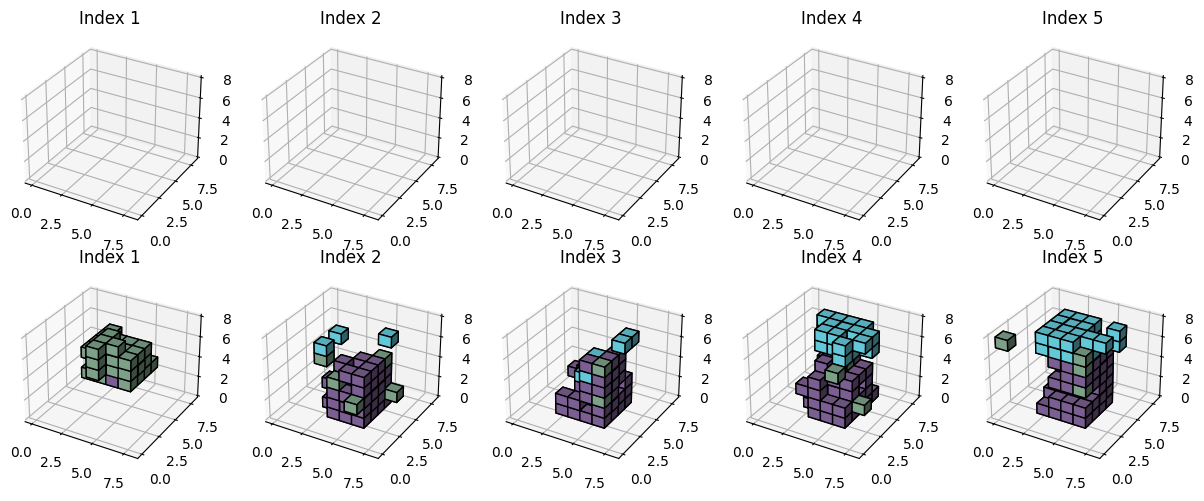

loss:0.453531414270401--iou_loss:0.645652174949646:  14%|█▍        | 207/1500 [04:50<30:11,  1.40s/it]   


KeyboardInterrupt: 

In [5]:
ct.train()

### View model weights

In [8]:
for name, W in ct.model.named_parameters():
    print(name, W)

perception_net.conv1.weight Parameter containing:
tensor([[[[[ 0.0272, -0.2656, -0.1063],
           [ 0.1028,  0.1063, -0.1737],
           [-0.0003, -0.0233,  0.0215]],

          [[ 0.0839, -0.0113, -0.2402],
           [-0.0893, -0.0661,  0.0871],
           [-0.0462,  0.0022, -0.0547]],

          [[ 0.0123,  0.0586,  0.0858],
           [ 0.0101, -0.0336, -0.0292],
           [-0.1408,  0.0626, -0.1119]]]],



        [[[[ 0.0038,  0.1121,  0.0272],
           [-0.0338, -0.0014,  0.0501],
           [-0.1201,  0.0701, -0.0216]],

          [[-0.0412, -0.0654,  0.0553],
           [-0.0176,  0.1187,  0.1306],
           [-0.0335,  0.0088,  0.0133]],

          [[-0.0577, -0.2168, -0.0293],
           [-0.0597,  0.0501,  0.0444],
           [-0.1438, -0.0079, -0.0434]]]],



        [[[[ 0.0847,  0.2049, -0.0655],
           [ 0.0915, -0.0873,  0.0567],
           [-0.0841,  0.0458,  0.0039]],

          [[-0.0867,  0.0886, -0.0330],
           [ 0.1483,  0.1076, -0.0234],
        

In [9]:
with torch.no_grad():
    for name, W in ct.model.named_parameters():
        W += torch.ones_like(W)

In [10]:
for name, W in ct.model.named_parameters():
    print(name, W)

perception_net.conv1.weight Parameter containing:
tensor([[[[[1.0272, 0.7344, 0.8937],
           [1.1028, 1.1063, 0.8263],
           [0.9997, 0.9767, 1.0215]],

          [[1.0839, 0.9887, 0.7598],
           [0.9107, 0.9339, 1.0871],
           [0.9538, 1.0022, 0.9453]],

          [[1.0123, 1.0586, 1.0858],
           [1.0101, 0.9664, 0.9708],
           [0.8592, 1.0626, 0.8881]]]],



        [[[[1.0038, 1.1121, 1.0272],
           [0.9662, 0.9986, 1.0501],
           [0.8799, 1.0701, 0.9784]],

          [[0.9588, 0.9346, 1.0553],
           [0.9824, 1.1187, 1.1306],
           [0.9665, 1.0088, 1.0133]],

          [[0.9423, 0.7832, 0.9707],
           [0.9403, 1.0501, 1.0444],
           [0.8562, 0.9921, 0.9566]]]],



        [[[[1.0847, 1.2049, 0.9345],
           [1.0915, 0.9127, 1.0567],
           [0.9159, 1.0458, 1.0039]],

          [[0.9133, 1.0886, 0.9670],
           [1.1483, 1.1076, 0.9766],
           [1.1045, 1.0123, 1.1335]],

          [[0.9251, 1.1018, 1.0923],
 

In [11]:
weights = ct.model.state_dict()

#### Save model

In [14]:
torch.save({"model":ct.model.state_dict()}, "test_model.pt")

#### Load Model

In [14]:
ct.load_model("test_model.pt", load_optimizer_and_scheduler = False)

### Create new trainer from pretrained model

In [13]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "pretrained_path":"test_model.pt",
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

### Visualize output of NCA

In [15]:
from IPython.display import clear_output
from artefact_nca.utils.minecraft.voxel_utils import replace_colors

def visualize_output(ct, out):
    clear_output()
    out = rearrange(out, 'b d h w c -> b w d h c')
    argmax = np.argmax(out[:, :, :, :, :ct.num_categories], -1)
    out = replace_colors(argmax, ct.dataset.target_color_dict)[0]
    fig = plt.figure()
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(out, facecolors=out, edgecolor='k')
    
    plt.show()
    return argmax

<Figure size 640x480 with 0 Axes>

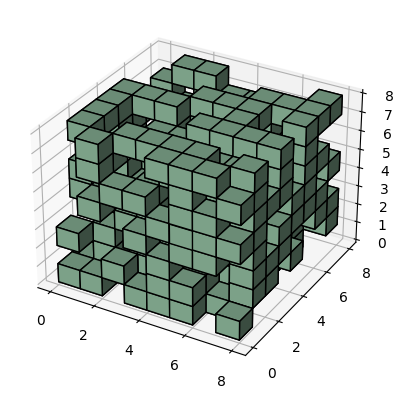

In [16]:
seed = np.ones(
            (1, 8, 8, 8, ct.num_channels)
        )
seed[:, :, :, :, 1:] = 10.0
seed = torch.from_numpy(seed).float().to(ct.device)

with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=seed)

_ = visualize_output(ct, final.cpu().numpy())

#### another step

<Figure size 640x480 with 0 Axes>

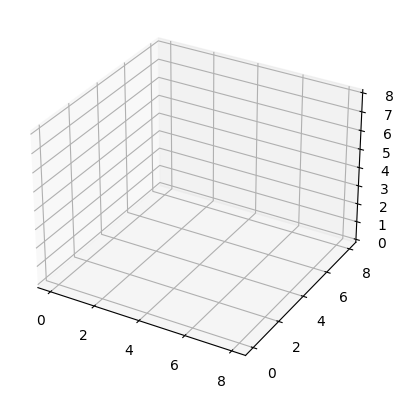

In [22]:
with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=final)

_ = visualize_output(ct, final.cpu().numpy())